In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['font.sans-serif']=['Microsoft Yahei']
plt.style.use("ggplot")

<div class="jumbotron">
    <h1 class="display-1">分类技术：进阶</h1>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

## 分类技术在评价中的应用

- 数据集记录了151名助教在5个学期中的教学效果的评估，评估结果分别是“差”、“一般”、“好”。数据属性的含义如下表所示：

No.|含义|取值
---|---|---
1|助教是否以英语为母语|二元变量，1=是，2=否
2|课程的讲师|分类变量，25个类别
3|课程|分类变量，26个类别
4|暑期或正常学期|二元变量，1=暑期，2=正常学期
5|班级大小|整数
6|评估结果|1=差，2=一般，3=好

### 读取数据

In [7]:
tadf = pd.read_csv('./data/classificationSupplement/tae.txt')
tadf.head()

,1,23,3,1.1,19,3.1
0,2,15,3,1,17,3
1,1,23,3,2,49,3
2,1,5,2,2,33,3
3,2,7,11,2,55,3
4,2,23,3,1,20,3


- 原始数据不含有属性（列）名，用上述方式导致将第一行数据作为列名，这种读取方式不正确

In [8]:
tadf = pd.read_csv('./data/classificationSupplement/tae.txt',names=['english','instructor','course','period','size','label'])
tadf.head()

,english,instructor,course,period,size,label
0,1,23,3,1,19,3
1,2,15,3,1,17,3
2,1,23,3,2,49,3
3,1,5,2,2,33,3
4,2,7,11,2,55,3


### 数据预处理

#### 缺失值检验

In [9]:
tadf.isna().sum(axis=0)

english       0
instructor    0
course        0
period        0
size          0
label         0
dtype: int64

- 不存在缺失值

#### `one-hot`编码

- 将评估结果列和其他属性分开

In [10]:
taX = tadf.iloc[:,:-1]
taY = tadf['label']
taX.head()
taY.head()

,english,instructor,course,period,size
0,1,23,3,1,19
1,2,15,3,1,17
2,1,23,3,2,49
3,1,5,2,2,33
4,2,7,11,2,55


0    3
1    3
2    3
3    3
4    3
Name: label, dtype: int64

- 对预测属性进行`one-hot`编码

In [11]:
taXOH = pd.get_dummies(taX,columns=['english','instructor','course','period'])
taXOH.head()

,size,english_1,english_2,instructor_1,instructor_2,instructor_3,instructor_4,instructor_5,instructor_6,instructor_7,...,course_19,course_20,course_21,course_22,course_23,course_24,course_25,course_26,period_1,period_2
0,19,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,17,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,49,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,33,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,55,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


### 分割训练集与检验集

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
taTrainX,taTestX,taTrainY,taTestY = train_test_split(taXOH,taY,test_size=0.25,random_state=10, stratify=taY)

- `stratify`：`None`或数组，如果是数组，表明按照类别分层抽样组成训练集和检验集，使得训练集和检验集中的类别的比例与原始数据集的类别比例近似相等

In [14]:
taTrainY.value_counts(normalize=True)      #训练集的类别比例
taTestY.value_counts(normalize=True)      #检验集的类别比例
taY.value_counts(normalize=True)          #原始数据的类别比例

3    0.345133
2    0.327434
1    0.327434
Name: label, dtype: float64

3    0.342105
2    0.342105
1    0.315789
Name: label, dtype: float64

3    0.344371
2    0.331126
1    0.324503
Name: label, dtype: float64

### 建立神经网络模型

In [15]:
from sklearn.neural_network import MLPClassifier

- 输入层神经元数量：56
    + `one-hot`编码后的预测属性的数量

- 输出层神经元数量：3
    + 评估类别的数量

- 隐藏层神经元数量：13

In [12]:
np.sqrt(56*3)

12.96148139681572

In [16]:
taAnn = MLPClassifier(hidden_layer_sizes=(13,),solver='lbfgs',activation='relu',learning_rate='constant',max_iter=3000,random_state=12)

### 训练神经网络模型

#### 管道（`pipeline`）命令

- 很多数据挖掘算法都会牵涉到多个步骤：标准化属性、建立模型、训练模型
- 可以用`pipeline`把这些步骤串联起来，训练的时候数据会依次经过每个步骤

<center><img src="./img/classificationSupplement/pipeline.png" width=80%></center>

```python
from sklearn.pipeline import Pipeline
Pipeline(steps)
```
- `steps`：变换阶段构成的**列表**，每个变换阶段用一个**元组**表示：`(变换阶段名称,变换函数)`
    + 例如，`[('scl',StandardScaler()),('ann',MLPClassifier())]`

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [18]:
pipeAnn = Pipeline([
    ('scl',StandardScaler()),
    ('ann', taAnn)
])

#### 交叉验证

- 交叉验证（cross-validation）：每个记录用于训练的次数相同，并且恰好检验一次

- $k$折交叉验证（k-folder cross-validation）

<img src="./img/classification/grid_search_cross_validation.jpg" width=100%>

- 交叉验证的步骤：

1. $k-1$折数据作为训练集训练模型

2. 剩下的1折数据作为验证集（validation set）测试分类模型的性能

3. 以所有循环性能度量的均值作为交叉验证的测试结果

- `sklearn`实现交叉验证

```python
from sklearn.model_selection import cross_val_score
cross_val_score(estimator, X, y=None, scoring=None, cv=None)
```
- `estimator`：构建的分类模型
- `X`：预测属性
- `y`：分类标签
- `scoring`：模型分类性能的评估函数，`str`类型
- `cv`：训练集的划分方法，`int`类型，表示具体的折数，默认是5折
- 返回值：每一次交叉验证的评估结果构成的列表

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
taRes = cross_val_score(pipeAnn,taTrainX,taTrainY,scoring='accuracy',cv=10,n_jobs=-1)
print(f'初始建立的神经网络模型预测的平均准确率是{taRes.mean():.4f}，标准差是{taRes.std():.4f}')

初始建立的神经网络模型预测的平均准确率是0.5568，标准差是0.1381


### 搜索最优参数

- 每个模型都有若干个参数(**超参, hyperparameters**)需要设置，但是事先我们并不知道如何设置参数最好，因此需要优化这些参数以取得更好的模型性能，即超参优化

- 一种朴素的想法是尝试所有参数的**组合**，从中选出最优的参数组合

- 网格(grid)搜索可以实现这样的目的

<center><img src="./img/classificationSupplement/grid_search.jpg" width=60%></center>

```python
from sklearn.model_selection import GridSearchCV
GridSearchCV(estimator, param_grid, scoring=None, n_jobs=None, cv=None, refit=True)
```
- `estimator`：待估计的模型，可以是用`pipeline`构成的模型
- `param_grid`：模型参数的可选范围，字典结构，字典的键（key）是参数名称，字典的值（value）是该参数的取值范围
    + 如果待估计模型是`pipeline`构成的，那么字典的键应该`变换阶段名称__参数名称`
- `refit`：`True`表明用选出的最优参数在所有训练集上进行训练

- `estimator`：待估计的模型，可以是用`pipeline`构成的模型
- `param_grid`：模型参数的可选范围，字典结构，字典的键（key）是参数名称，字典的值（value）是该参数的取值范围
    + 如果待估计模型是`pipeline`构成的，那么字典的键应该`变换阶段名称__参数名称`

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
taAnnParams = {
    'ann__hidden_layer_sizes':range(13,56),
    'ann__activation':['relu','logistic','tanh'],
    'ann__learning_rate':['constant','invscaling'],
}

In [20]:
taAnnGs = GridSearchCV(pipeAnn,param_grid=taAnnParams,cv=10,n_jobs=-1)

In [21]:
%%time
taAnnGs.fit(taTrainX,taTrainY)

CPU times: user 10.9 s, sys: 172 ms, total: 11 s
Wall time: 19min 47s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('ann',
                                        MLPClassifier(hidden_layer_sizes=(13,),
                                                      max_iter=3000,
                                                      random_state=12,
                                                      solver='lbfgs'))]),
             n_jobs=-1,
             param_grid={'ann__activation': ['relu', 'logistic', 'tanh'],
                         'ann__hidden_layer_sizes': range(13, 56),
                         'ann__learning_rate': ['constant', 'invscaling']})

#### 网格搜索的常用属性

- `best_params_`：最优参数组合

In [22]:
taAnnGs.best_params_

{'ann__activation': 'logistic',
 'ann__hidden_layer_sizes': 18,
 'ann__learning_rate': 'constant'}

- `best_score_`：最优的性能指标

In [23]:
taAnnGs.best_score_

0.6712121212121211

- `best_estimator_`：训练的最优模型

In [24]:
taAnnOptimal = taAnnGs.best_estimator_
taAnnOptimal

Pipeline(steps=[('scl', StandardScaler()),
                ('ann',
                 MLPClassifier(activation='logistic', hidden_layer_sizes=18,
                               max_iter=3000, random_state=12,
                               solver='lbfgs'))])

##### 检验分类准确率

In [26]:
from sklearn import metrics

In [27]:
print(f'筛选的神经网络模型在完整训练集上的准确率是{metrics.accuracy_score(taTrainY,taAnnOptimal.predict(taTrainX)):.4f}')

筛选的神经网络模型在完整训练集上的准确率是0.9735


In [28]:
print(f'筛选的神经网络模型在检验集上的准确率是{metrics.accuracy_score(taTestY,taAnnOptimal.predict(taTestX)):.4f}')

筛选的神经网络模型在检验集上的准确率是0.6579


#### 随机网格搜索

```python
from sklearn.model_selection import RandomizedSearchCV
RandomizedSearchCV(estimator, param_distributions, n_iter=10, scoring=None, n_jobs=None, refit=True, cv=None, random_state=None)
```
- `param_distributions`：字典结构，`{参数名称: 参数取值分布或列表}`
- 参数取值分布：一般选用scipy.stats.distributions中的分布类型
    - 连续变量：[https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html](https://docs.scipy.org/doc/scipy/tutorial/stats/continuous.html)
    - 离散变量：[https://docs.scipy.org/doc/scipy/tutorial/stats/discrete.html#](https://docs.scipy.org/doc/scipy/tutorial/stats/discrete.html#)
- 参数取值列表：从列表中均匀随机抽取

In [21]:
from sklearn.model_selection import RandomizedSearchCV
taAnnParamsRandom = {
    'ann__hidden_layer_sizes':stats.randint(13,56),
    'ann__activation':['relu','logistic','tanh'],
    'ann__learning_rate':['constant','invscaling']
}

In [25]:
taAnnRs = RandomizedSearchCV(pipeAnn, taAnnParamsRandom, n_jobs=-1, cv=10, random_state=100)

In [26]:
%%time
taAnnRs.fit(taTrainX,taTrainY)

CPU times: user 4.26 s, sys: 20 ms, total: 4.28 s
Wall time: 1min 53s


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scl', StandardScaler()),
                                             ('ann',
                                              MLPClassifier(hidden_layer_sizes=(13,),
                                                            max_iter=3000,
                                                            random_state=12,
                                                            solver='lbfgs'))]),
                   n_jobs=-1,
                   param_distributions={'ann__activation': ['relu', 'logistic',
                                                            'tanh'],
                                        'ann__hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fbe63ea7438>,
                                        'ann__learning_rate': ['constant',
                                                               'invscaling']},
                   random_state=100)

In [28]:
taAnnRs.best_estimator_

Pipeline(steps=[('scl', StandardScaler()),
                ('ann',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=37,
                               learning_rate='invscaling', max_iter=3000,
                               random_state=12, solver='lbfgs'))])

#### Optuna参数优化package

- 一个高效的机器学习模型、深度学习模型的超参优化package
- 网址：[https://optuna.org](https://optuna.org)

- 可以用于`scikit-learn`、`PyTorch`、`TensorFlow`、`Keras`、`MXNet`框架的超参优化

- 安装：

```python
pip install optuna
```

- 安装仪表板

```python
pip install optuna-dashboard
```

- Study: 基于目标函数的优化过程

- Trial: 目标函数的单次执行过程

```python
def objective_fn(trial,trainX,trainY):
    
    hiddenNos = trial.suggest_int('hiddenNos',10,80,2)
    # 浮点数用suggest_float()
    
    lr = trial.suggest_categorical('lr',['constant','invscaling'])
    activation = trial.suggest_categorical('activation',['logistic','relu','tanh'])
    clf = MLPClassifier(hidden_layer_sizes=(hiddenNos,),activation=activation,learning_rate=lr,random_state=100,max_iter=3000)

    res = model_selection.cross_val_score(clf,trainX.values,trainY.values,scoring='accuracy',cv=5,n_jobs=-1)

    return res.mean()
```

```python
%%time
study = optuna.create_study(direction='maximize',storage="sqlite:///db.sqlite3")
# direction='minimize'
# storage: 将优化结果存储在sqlite3数据库中，便于之后用optuna_dashboard打开

study.optimize(lambda trial: objective_fn(trial,taTrainX,taTrainY),n_trials=100)
# 用lambda函数处理objective_fn中的自定义参数
print(study.best_trial)
```

### 建立决策树模型

In [29]:
from sklearn import tree

In [30]:
taDt = tree.DecisionTreeClassifier(ccp_alpha=0.035,random_state=10)

#### 获得后剪枝`ccp_alpha`值列表

In [31]:
taCcpPath = taDt.cost_complexity_pruning_path(taTrainX,taTrainY)
taAlphas = taCcpPath['ccp_alphas']

#### 网格搜索最优`ccp_alpha`

In [32]:
taDtGs = GridSearchCV(estimator=taDt,param_grid={'ccp_alpha':taAlphas[:-1]},scoring='accuracy',cv=10,n_jobs=-1)

In [33]:
%%time
taDtGs.fit(taTrainX,taTrainY)

CPU times: user 272 ms, sys: 8 ms, total: 280 ms
Wall time: 1.26 s


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(ccp_alpha=0.035, random_state=10),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.        , 0.00255654, 0.00294985, 0.00393314, 0.00505689,
       0.00821745, 0.00884956, 0.01061947, 0.01061947, 0.01144185,
       0.01179941, 0.01179941, 0.01300617, 0.01327434, 0.01327434,
       0.01348504, 0.01359039, 0.01395602, 0.0142054 , 0.01591893,
       0.01806785, 0.02000158, 0.02437759, 0.02654867])},
             scoring='accuracy')

In [34]:
taDtGs.best_params_

{'ccp_alpha': 0.005056890012642226}

In [35]:
taDtGs.best_score_

0.6007575757575758

In [36]:
taDtOptimal = taDtGs.best_estimator_

#### 可视化决策规则

In [37]:
from graphviz import Source

array([1, 2, 3])

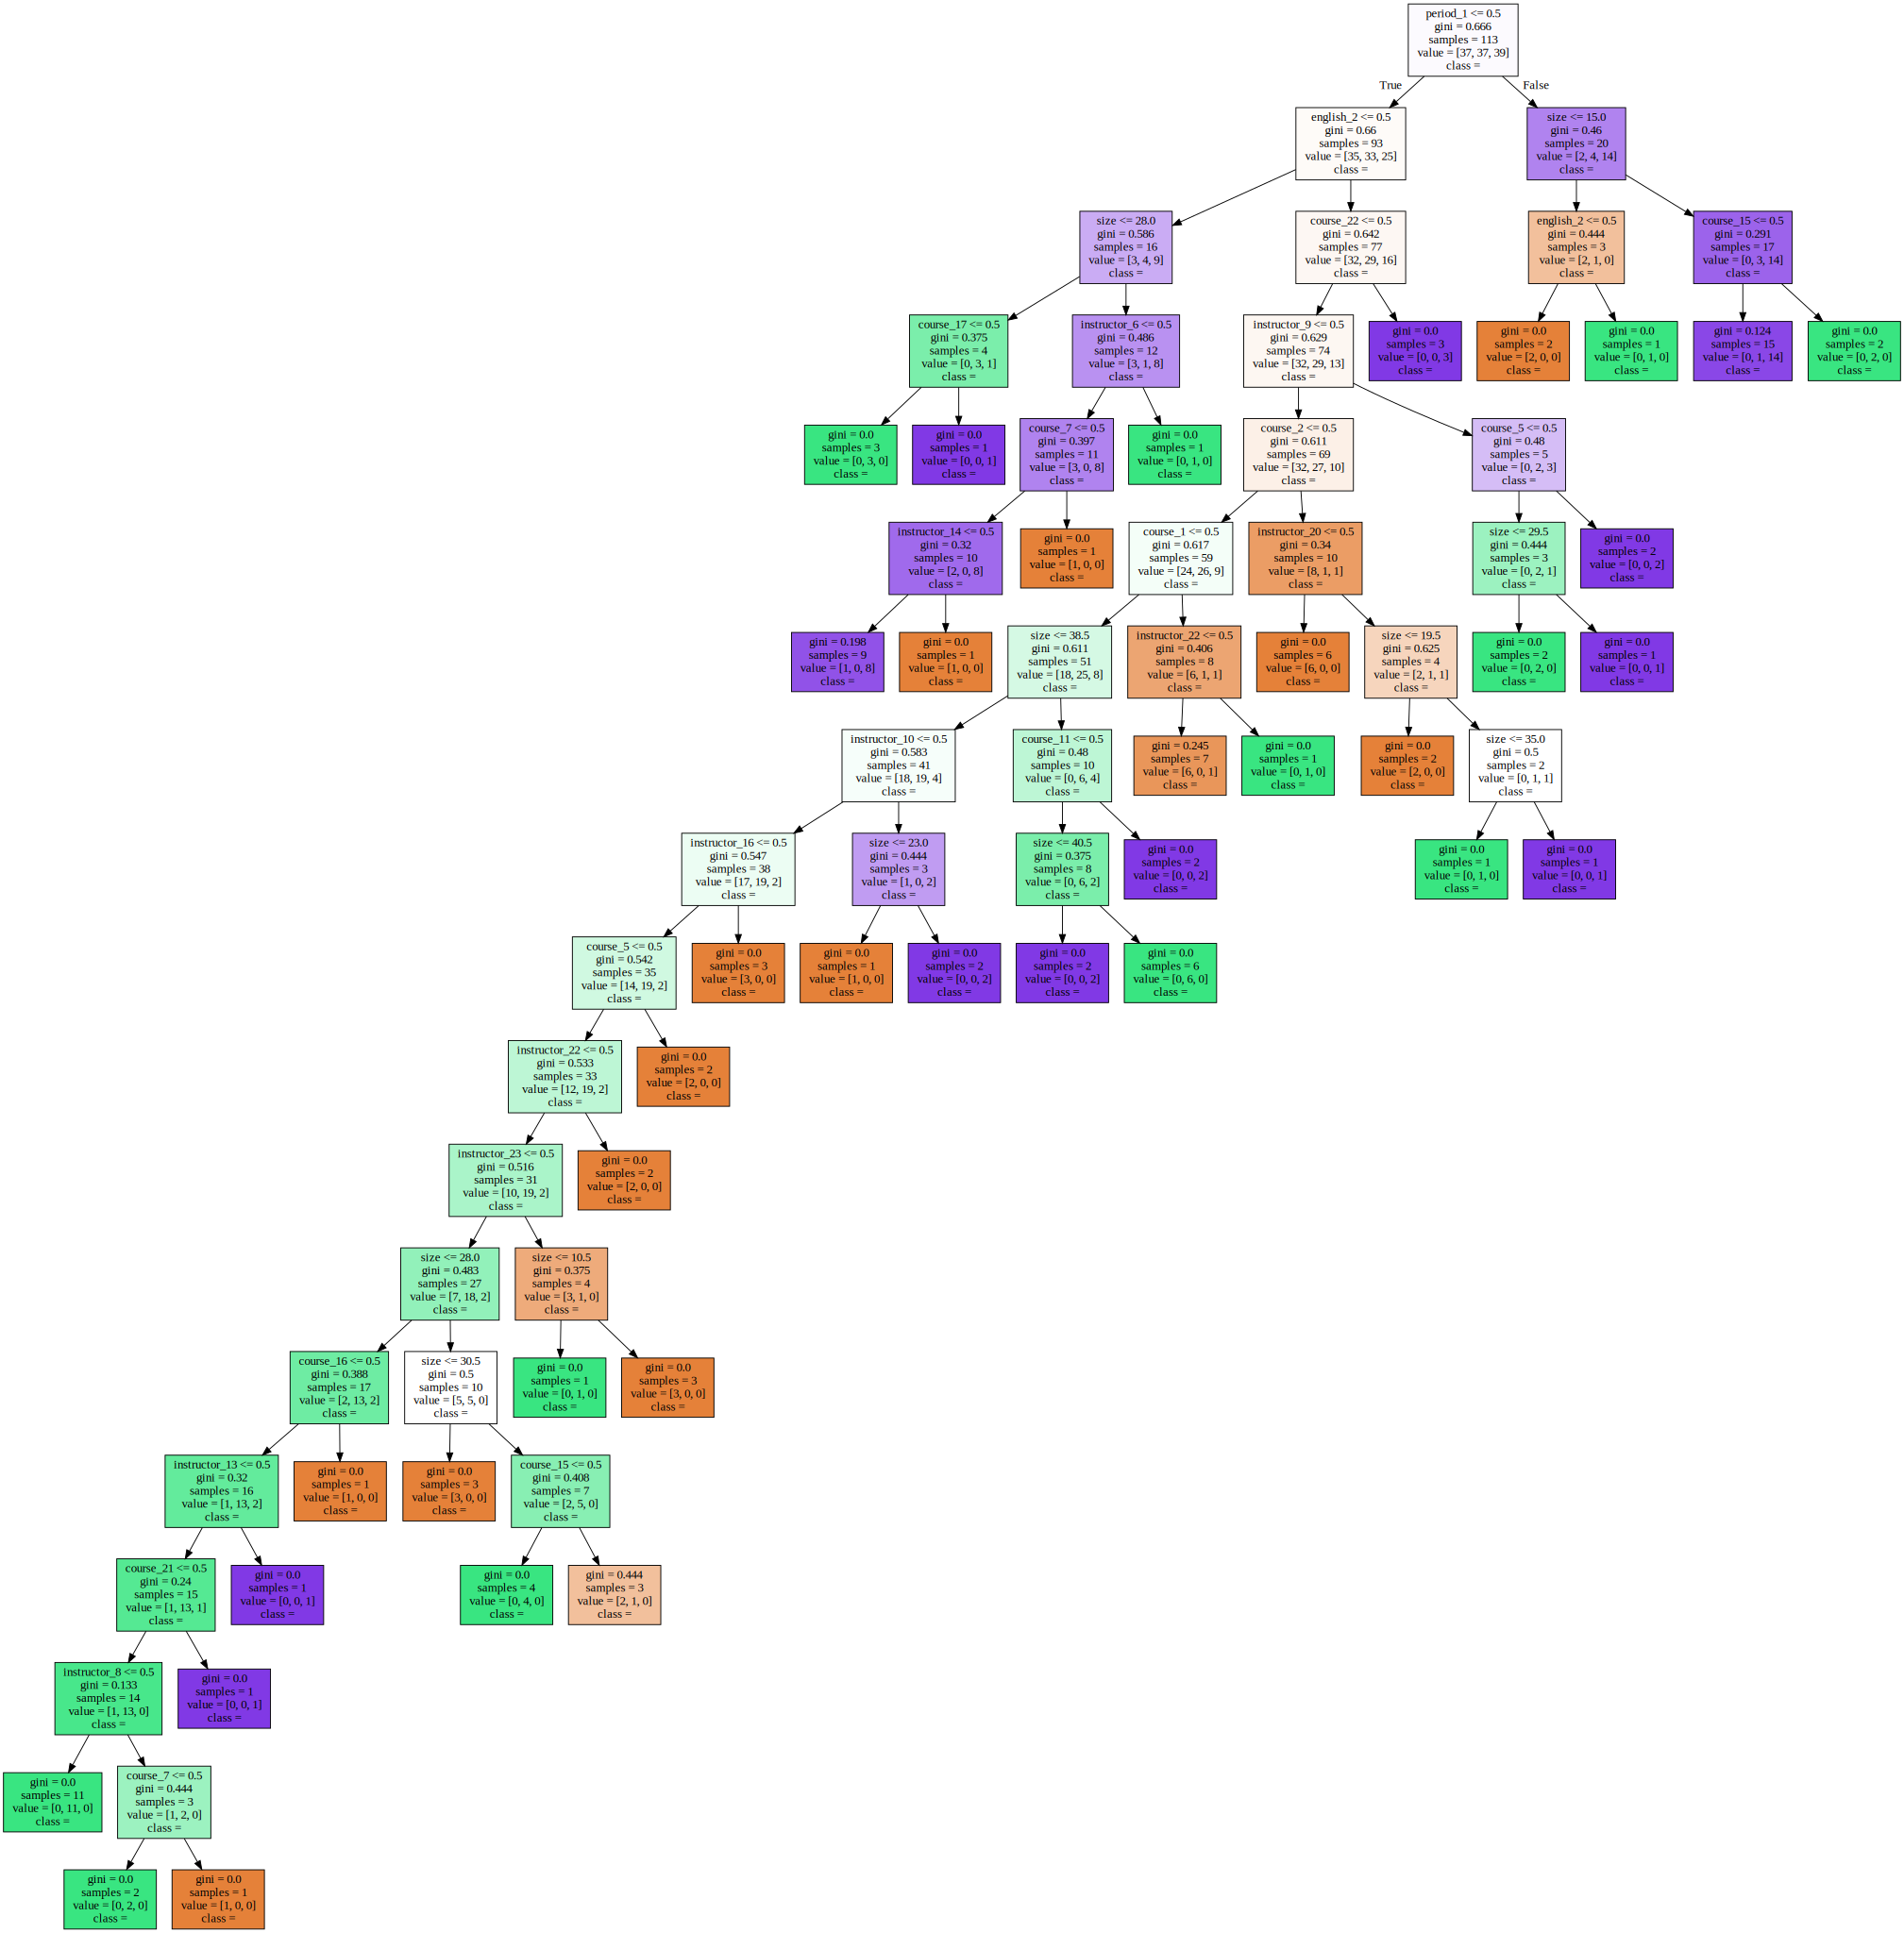

In [38]:
taDot = tree.export_graphviz(taDtOptimal,feature_names=taTrainX.columns,class_names=['差','一般','好'],filled=True)
taAnnOptimal.classes_
taGraphviz = Source(taDot)
taGraphviz

#### 在完整训练集和检验集上检验

In [39]:
print(f'筛选的决策树模型在完整训练集上的准确率是{metrics.accuracy_score(taTrainY,taDtOptimal.predict(taTrainX)):.4f}')

筛选的决策树模型在完整训练集上的准确率是0.9646


In [40]:
print(f'筛选的决策树模型在检验集上的准确率是{metrics.accuracy_score(taTestY,taDtOptimal.predict(taTestX)):.4f}')

筛选的决策树模型在检验集上的准确率是0.5000


## 分类技术在直接营销中的应用

- 一家银行开展一项直接营销的活动，通过电话联系客户让他们在该银行储蓄
- 目标是预测一个客户是否会来该银行储蓄

### 读取数据

In [41]:
dmDf = pd.read_csv('./data/classificationSupplement/bank_direct_marketing.csv')
dmDf.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"30;""unemployed"";""married"";""primary"";""no"";1787;..."
1,"33;""services"";""married"";""secondary"";""no"";4789;..."
2,"35;""management"";""single"";""tertiary"";""no"";1350;..."
3,"30;""management"";""married"";""tertiary"";""no"";1476..."
4,"59;""blue-collar"";""married"";""secondary"";""no"";0;..."


```python
pd.read_csv(sep=',')
```
- `sep`：每行元素之间的分隔符，默认是逗号

In [42]:
dmDf = pd.read_csv('./data/classificationSupplement/bank_direct_marketing.csv',sep=';')
dmDf.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


属性名称|含义|取值
---|---|---
age|年龄|数值型
job|工作|标称型
marital|婚姻状况|标称型
education|教育水平|序列型
default|是否有违约行为|二元型,yes或no
balance|平均年账户余额|数值型
housing|是否有购房贷款|二元型，yes或no
loan|是否有个人贷款|二元型,yes或no
contact|联系方式|标称型
day|在此次营销中最后一次与客户电话沟通发生在本月的第几天|数值型
month|在此次营销中最后一次与客户电话沟通发生在本年度的第几月|区间型
duration|在此次营销中最后一次与客户电话沟通的时间长度|数值型
campaign|在此次营销活动中与该客户沟通的次数|数值型
pdays|在上一次营销活动中该客户沟通距现在的天数|数值型，-1表示没有被沟通
previous|在此次营销活动之前该客户被沟通的次数|数值型
poutcome|上次营销活动的结果|标称型
y|该客户是否申请了定期储蓄|二元型，yes或no

In [43]:
dmDf.shape
dmDf.dtypes

(4521, 17)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

### 探索数据

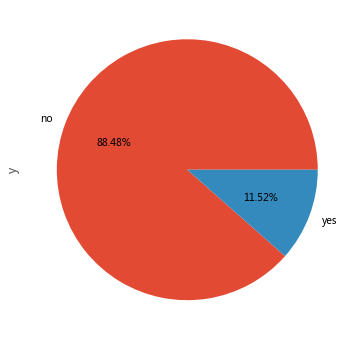

In [44]:
dmDf['y'].value_counts().plot(kind='pie',figsize=(12,6),autopct='%.2f%%')

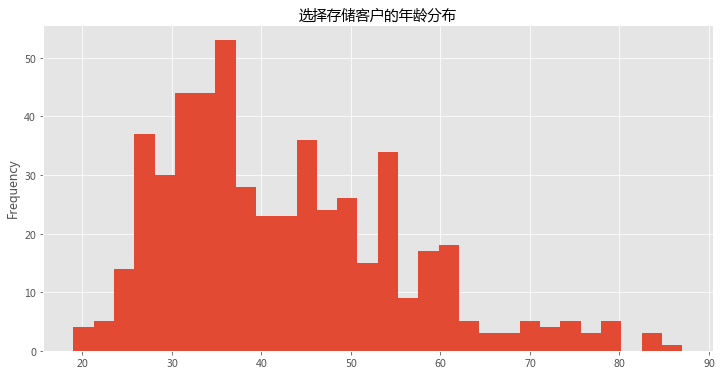

In [45]:
dmDf.loc[dmDf['y']=='yes','age'].plot(kind='hist',bins=30,figsize=(12,6),title='选择存储客户的年龄分布')

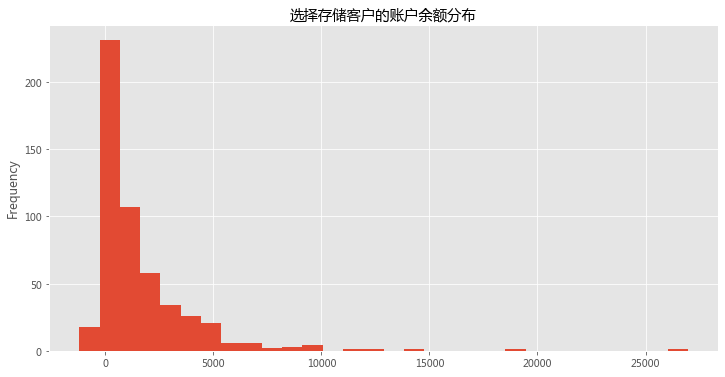

In [46]:
dmDf.loc[dmDf['y']=='yes','balance'].plot(kind='hist',bins=30,figsize=(12,6),title='选择存储客户的账户余额分布')

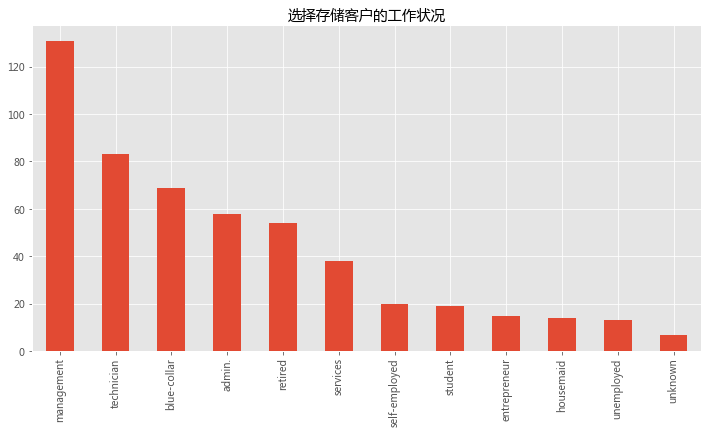

In [47]:
dmDf.loc[dmDf['y']=='yes','job'].value_counts().plot(kind='bar',figsize=(12,6),title='选择存储客户的工作状况')

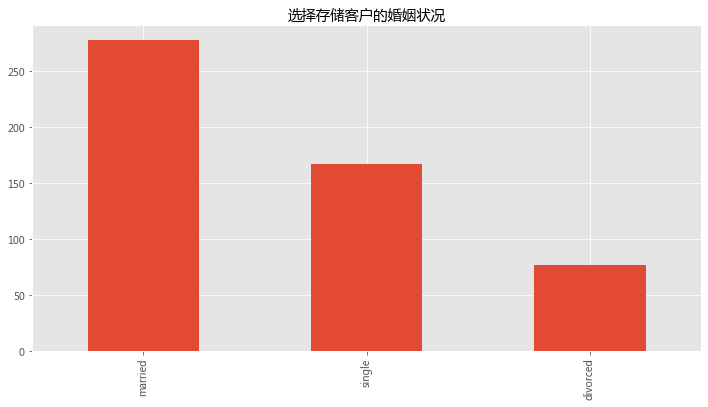

In [48]:
dmDf.loc[dmDf['y']=='yes','marital'].value_counts().plot(kind='bar',figsize=(12,6),title='选择存储客户的婚姻状况')

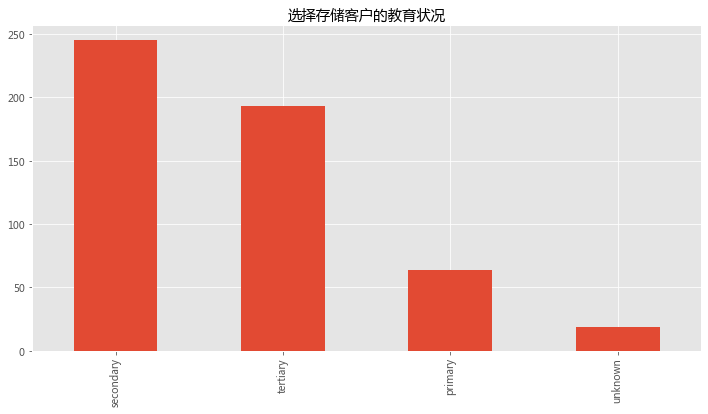

In [49]:
dmDf.loc[dmDf['y']=='yes','education'].value_counts().plot(kind='bar',figsize=(12,6),title='选择存储客户的教育状况')

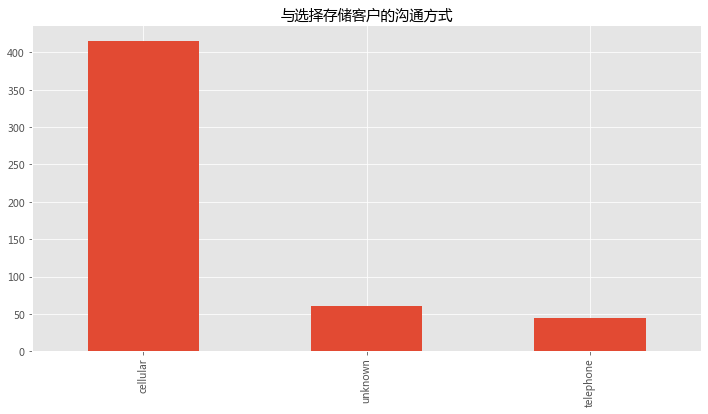

In [50]:
dmDf.loc[dmDf['y']=='yes','contact'].value_counts().plot(kind='bar',figsize=(12,6),title='与选择存储客户的沟通方式')

### 维度规约

#### 为什么要维度规约？

- 降低维度灾难（curse of dimensionality）

<dl class="row alert-danger">
    <dt class="col-md-4">维度灾难</dt>
    <dd class="col-md-8">随着属性数量的增加，没有足够多的数据点创建模型，很多数据挖掘算法的效果显著降低</dd>
</dl>

- 降低过度拟合
    + 属性过多，形成的分类规则复杂，过度适应训练集

#### 维度规约的方法

<center><img src="./img/classificationSupplement/dimension_reduction.png" width=100%></center>

- 特征选择的原因
    + **不相关特征**：一些属性与分类结果无关，例如学生ID与学生成绩没有明显联系
    + **冗余特征**：若干个属性之间信息重复，例如购买的产品价格与支付的消费税都包含了同样的信息

- 特征选择的方法
    + 领域知识判断
    + 单变量统计检验：判断每个属性与分类变量之间的相关性
    + 嵌入到数据挖掘过程中：一些挖掘算法本身在计算过程中会筛选属性，例如决策树

- 特征提取的原因
    + **共线性问题**：一些属性之间高度相关，影响例如回归分析中的系数准确性

- 特征提取的方法
    + 主成分分析（Principal component analysis, PCA）：将原始属性通过线性变换为互相正交的少数主成分，即新属性

#### 单变量统计筛选属性

##### 标称、序列型属性与分类结果的线性相关性检验

In [51]:
from scipy import stats

In [52]:
crtJob = pd.crosstab(dmDf['job'],dmDf['y'],margins=True)
crtJob

y,no,yes,All
job,,,
admin.,420,58,478
blue-collar,877,69,946
entrepreneur,153,15,168
housemaid,98,14,112
management,838,131,969
retired,176,54,230
self-employed,163,20,183
services,379,38,417
student,65,19,84


In [53]:
chiJob,pvJob,_,_ = stats.chi2_contingency(crtJob)
print(f'卡方值为{chiJob:.3f},p值为{pvJob:.3f}')

卡方值为68.988,p值为0.000


In [54]:
for each in ['job','marital','default','housing','loan','contact','poutcome']:
    crtb = pd.crosstab(dmDf[each],dmDf['y'],margins=True)
    chi,pv,_,_ = stats.chi2_contingency(crtb)
    print(f'{each}和存储与否的卡方值为{chi:.3f},p值为{pv:.3f}')

job和存储与否的卡方值为68.988,p值为0.000
marital和存储与否的卡方值为19.030,p值为0.004
default和存储与否的卡方值为0.008,p值为1.000
housing和存储与否的卡方值为49.544,p值为0.000
loan和存储与否的卡方值为22.481,p值为0.000
contact和存储与否的卡方值为87.870,p值为0.000
poutcome和存储与否的卡方值为386.877,p值为0.000


##### 区间、比率型属性与分类结果的线性相关性检验

###### 将分类结果转变为数值型

In [55]:
dmDf['y'].unique()

array(['no', 'yes'], dtype=object)

```python
pandas.factorize(values, sort = False, na_sentinel = -1)
```
- `values`：需要转换的分类属性
- `sort`：是否对类别排序
- `na_sentinel`：替换需要转换的分类属性中的缺失值
- 返回包含两个元素的元组，分别是转换为数值的属性、原属性中的所有独特类别

In [56]:
yVal,_ = pd.factorize(dmDf['y'],sort=True)
yVal

array([0, 0, 0, ..., 0, 0, 0])

###### 将序列属性转换为数值

In [57]:
dmDf['education'].unique()
dmDf['month'].unique()

array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object)

array(['oct', 'may', 'apr', 'jun', 'feb', 'aug', 'jan', 'jul', 'nov',
       'sep', 'mar', 'dec'], dtype=object)

In [58]:
dmDf['education'].replace({'primary':1,'secondary':2,'tertiary':3,'unknown':0},inplace=True)
dmDf['month'].replace({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12},inplace=True)
dmDf.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,1,no,1787,no,no,cellular,19,10,79,1,-1,0,unknown,no
1,33,services,married,2,no,4789,yes,yes,cellular,11,5,220,1,339,4,failure,no
2,35,management,single,3,no,1350,yes,no,cellular,16,4,185,1,330,1,failure,no
3,30,management,married,3,no,1476,yes,yes,unknown,3,6,199,4,-1,0,unknown,no
4,59,blue-collar,married,2,no,0,yes,no,unknown,5,5,226,1,-1,0,unknown,no


In [59]:
for each in ['age','education','balance','day','duration','campaign','month','pdays','previous']:
    r,pv = stats.pearsonr(dmDf[each],yVal)
    print(f'{each}和存储与否的相关系数是{r:.3f}，显著性是{pv:.3f}')

age和存储与否的相关系数是0.045，显著性是0.002
education和存储与否的相关系数是0.050，显著性是0.001
balance和存储与否的相关系数是0.018，显著性是0.229
day和存储与否的相关系数是-0.011，显著性是0.450
duration和存储与否的相关系数是0.401，显著性是0.000
campaign和存储与否的相关系数是-0.061，显著性是0.000
month和存储与否的相关系数是0.023，显著性是0.117
pdays和存储与否的相关系数是0.104，显著性是0.000
previous和存储与否的相关系数是0.117，显著性是0.000


In [60]:
dmX = dmDf.loc[:,['age','job','marital','education','housing','loan','contact','campaign','pdays','previous','poutcome']]
dmY = dmDf['y']
dmX.head()
dmY.head()

,age,job,marital,education,housing,loan,contact,campaign,pdays,previous,poutcome
0,30,unemployed,married,1,no,no,cellular,1,-1,0,unknown
1,33,services,married,2,yes,yes,cellular,1,339,4,failure
2,35,management,single,3,yes,no,cellular,1,330,1,failure
3,30,management,married,3,yes,yes,unknown,4,-1,0,unknown
4,59,blue-collar,married,2,yes,no,unknown,1,-1,0,unknown


0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

### 数据预处理

#### `one-hot`编码

In [61]:
dmXOH = pd.get_dummies(dmX,columns=['job','marital','housing','loan','contact','poutcome','education'])
dmXOH.head()

,age,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,education_0,education_1,education_2,education_3
0,30,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,33,1,339,4,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,35,1,330,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,30,4,-1,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
4,59,1,-1,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


### 划分训练集与检验集

In [62]:
dmTrX,dmTeX,dmTrY,dmTeY = train_test_split(dmXOH,dmY,test_size=0.25,stratify=dmY,random_state=10)

### 建立神经网络模型

- 隐藏层神经元初始数量

In [30]:
np.sqrt(34*1)

5.830951894845301

#### 建立管道模型

In [64]:
dmPipe = Pipeline([
    ('scl',StandardScaler()),
    ('ann',MLPClassifier(max_iter=3000,random_state=12))
])

#### 网格搜索最优参数

##### 自定义得分函数
- 处理`pos_label`默认值不是1的情况

```python
metrics.make_scorer(score_func, **kwargs)
```
- `score_func`：分类性能函数
- `**kwargs`：`score_func`需要的参数
- 例如，如果`score_func=f1_score`，那么`**kwargs`位置则可写`pos_label='yes'`

In [65]:
from sklearn.metrics import recall_score,make_scorer,f1_score

In [66]:
my_scorer = make_scorer(f1_score, pos_label='yes')

In [67]:
dmParams = {
    'ann__hidden_layer_sizes':range(6,62,20),
    'ann__learning_rate':['constant','invscaling'],
    'ann__activation':['relu','logistic','tanh'],
}

In [68]:
dmGs = GridSearchCV(estimator=dmPipe,param_grid=dmParams,scoring=my_scorer,cv=5,n_jobs=-1)

In [69]:
%%time
dmGs.fit(dmTrX,dmTrY)

CPU times: user 16.3 s, sys: 12 ms, total: 16.3 s
Wall time: 4min 45s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('ann',
                                        MLPClassifier(max_iter=3000,
                                                      random_state=12))]),
             n_jobs=-1,
             param_grid={'ann__activation': ['relu', 'logistic', 'tanh'],
                         'ann__hidden_layer_sizes': range(6, 62, 20),
                         'ann__learning_rate': ['constant', 'invscaling']},
             scoring=make_scorer(f1_score, pos_label=yes))

In [70]:
dmGs.best_params_

{'ann__activation': 'tanh',
 'ann__hidden_layer_sizes': 26,
 'ann__learning_rate': 'constant'}

In [71]:
dmGs.best_score_

0.24377937637090524

In [72]:
dmAnnOpt = dmGs.best_estimator_

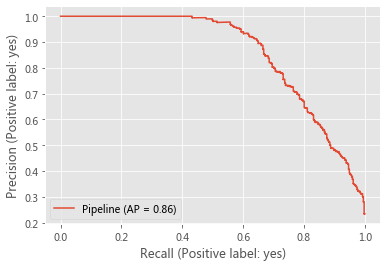

In [73]:
metrics.plot_precision_recall_curve(dmAnnOpt,dmTrX,dmTrY,pos_label="yes")

#### 性能检验

In [74]:
print(f'建立的神经网络模型在检验集上的准确率是{metrics.accuracy_score(dmTeY,dmAnnOpt.predict(dmTeX)):.4f}')

建立的神经网络模型在检验集上的准确率是0.8453


In [75]:
print(f'建立的神经网络模型在检验集上对存储的召回率是{metrics.recall_score(dmTeY,dmAnnOpt.predict(dmTeX),pos_label="yes"):.4f}')

建立的神经网络模型在检验集上对存储的召回率是0.1846


In [76]:
print(f'建立的神经网络模型在检验集上对未存储的召回率是{metrics.recall_score(dmTeY,dmAnnOpt.predict(dmTeX),pos_label="no"):.4f}')

建立的神经网络模型在检验集上对未存储的召回率是0.9311


### 类别样本数量不平衡

<dl class="row alert-danger">
    <dt class="col-md-4">类不平衡</dt>
    <dd class="col-md-8">在训练分类器中所使用的训练集的类别分布不均</dd>
</dl>

- 不利影响
    + 某个类别的样本太少，提供的信息就少，分类算法不会学习对该类型的识别
    + 导致分类模型的**准确率**高，但是对于该类的**召回率**低

- 解决方法
    + 过采样（over-sampling）：对训练集里面样本数量较少的类别进行多次抽样，合成新的样本
        - SMOTE(Synthetic Minority Over-sampling)算法
    + 欠采样（under-sampling）： 抛弃训练集里面样本数量较多的类别的一些样本

#### 处理样本类别不平衡的包

- `imbalanced-learn`
    + [https://imbalanced-learn.org/stable/](https://imbalanced-learn.org/stable/)

- 安装方法：

```python
pip install -U imbalanced-learn
conda install -c conda-forge imbalanced-learn
```

- 使用方法
    + 导入过采样函数：`from imblearn.over_sampling import SMOTE`
    + 导入管道函数：`import imblearn.pipeline as imbpipe`

#### 用过采样方法重新训练神经网络模型

In [77]:
from imblearn.over_sampling import SMOTE
import imblearn.pipeline as imbpipe

In [78]:
dmImbPipe = imbpipe.Pipeline([
    ('scl',StandardScaler()),
    ('sampling',SMOTE(random_state=0,n_jobs=-1)),
    ('ann',MLPClassifier(solver='lbfgs',max_iter=3000,random_state=12))
])

In [79]:
dmImbGs = GridSearchCV(estimator=dmImbPipe,param_grid=dmParams,scoring=recall_scorer,cv=5,n_jobs=2)

In [80]:
%%time
dmImbGs.fit(dmTrX,dmTrY)

CPU times: user 4.32 s, sys: 1.98 s, total: 6.3 s
Wall time: 24min 7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', StandardScaler()),
                                       ('sampling',
                                        SMOTE(n_jobs=-1, random_state=0)),
                                       ('ann',
                                        MLPClassifier(max_iter=3000,
                                                      random_state=12,
                                                      solver='lbfgs'))]),
             n_jobs=2,
             param_grid={'ann__activation': ['relu', 'logistic', 'tanh'],
                         'ann__hidden_layer_sizes': range(6, 62, 20),
                         'ann__learning_rate': ['constant', 'invscaling']},
             scoring=make_scorer(f1_score, pos_label=yes))

In [81]:
dmImbGs.best_params_

{'ann__activation': 'relu',
 'ann__hidden_layer_sizes': 6,
 'ann__learning_rate': 'constant'}

In [82]:
dmImbGs.best_score_

0.27045835395724105

In [83]:
dmImbAnnOpt = dmImbGs.best_estimator_

In [84]:
print(f'建立的神经网络模型在检验集上的准确率是{metrics.accuracy_score(dmTeY,dmImbAnnOpt.predict(dmTeX)):.4f}')

建立的神经网络模型在检验集上的准确率是0.7073


In [85]:
print(f'建立的神经网络模型在检验集上对订阅的召回率是{metrics.recall_score(dmTeY,dmImbAnnOpt.predict(dmTeX),pos_label="yes"):.4f}')

建立的神经网络模型在检验集上对订阅的召回率是0.3923


In [86]:
print(f'建立的神经网络模型在检验集上对订阅的召回率是{metrics.recall_score(dmTeY,dmAnnOpt.predict(dmTeX),pos_label="no"):.4f}')

建立的神经网络模型在检验集上对订阅的召回率是0.9311


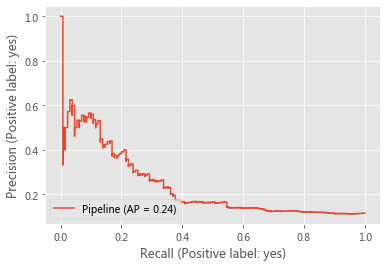

In [87]:
metrics.plot_precision_recall_curve(dmImbAnnOpt,dmTeX,dmTeY,pos_label="yes")

### 建立决策树模型

#### 建立模型

In [88]:
dmTree = tree.DecisionTreeClassifier(ccp_alpha=0.2,class_weight='balanced',random_state=14)

- `class_weight`：给类别赋权重，调整样本类别不均衡
    + `balanced`根据数据中的分类变量中各个类比出现的频率自动计算类别权重，频率越低，权重越大

#### 获得后剪枝`ccp_alpha`列表

In [89]:
dmCcpPath = dmTree.cost_complexity_pruning_path(dmTrX,dmTrY)
dmAlphas = dmCcpPath['ccp_alphas']

#### 网格搜索最优参数

In [90]:
dmTreeGs = GridSearchCV(estimator=dmTree,param_grid={'ccp_alpha':dmAlphas[:-1]},scoring=recall_scorer,cv=5,n_jobs=-1)

In [91]:
%%time
dmTreeGs.fit(dmTrX,dmTrY)

CPU times: user 1.55 s, sys: 60 ms, total: 1.61 s
Wall time: 23.9 s


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(ccp_alpha=0.2,
                                              class_weight='balanced',
                                              random_state=14),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([0.00000000e+00, 0.00000000e+00, 1.85098870e-19, 1.85098870e-19,
       1.85098870e-19, 1.85098870e-19, 3.70197741e-19, 5.55296611e-19,
       5.55296611e-19, 1.38824153e-18, 2.49883475e-18, 4.14621470e-18,
       1.80527834e-05, 1.805278...
       1.70560937e-03, 1.72955864e-03, 1.74329781e-03, 1.82651503e-03,
       1.85161539e-03, 1.88855382e-03, 2.02692733e-03, 2.09076195e-03,
       2.12134645e-03, 2.17231586e-03, 2.19397371e-03, 2.39086550e-03,
       2.58032224e-03, 2.71512907e-03, 2.83957563e-03, 3.07784466e-03,
       3.09410368e-03, 3.14399137e-03, 5.58607053e-03, 7.93542536e-03,
       2.29880960e-02])},
             scoring=make_scorer(f1_score, pos_label=yes))

In [92]:
dmTreeGs.best_params_

{'ccp_alpha': 0.003077844659605089}

In [93]:
dmTreeGs.best_score_

0.3106444262498338

In [94]:
dmTreeOpt = dmTreeGs.best_estimator_

#### 性能检验

In [95]:
print(f'建立的决策树模型在检验集上的准确率是{metrics.accuracy_score(dmTeY,dmTreeOpt.predict(dmTeX)):.4f}')

建立的决策树模型在检验集上的准确率是0.6401


In [96]:
print(f'建立的决策树模型在检验集上对存储的召回率是{metrics.recall_score(dmTeY,dmTreeOpt.predict(dmTeX),pos_label="yes"):.4f}')

建立的决策树模型在检验集上对存储的召回率是0.6000


In [97]:
print(f'建立的决策树模型在检验集上对不存储的召回率是{metrics.recall_score(dmTeY,dmTreeOpt.predict(dmTeX),pos_label="no"):.4f}')

建立的决策树模型在检验集上对不存储的召回率是0.6454
